# Chapter 9 - The General Counterfactual Inference Algorithm

The notebook is a code companion to chapter 9 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/). View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%209/Chapter_9_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Listing 9.1 Installing graphviz and helper functions

We start by loading some helper functions. A `plot_graph` helper function will help us visualize the graphs. Graphviz installation depends on your environment, this code worked for Ubuntu 22.04. If you get stuck, you can always run the rest of the code without the graph plots.

We also download some utilities from Github. `download_code` will fetch the code as a string without executing. It is good security practice to inspect code you download from the Internet before executing. After inspection, uncomment the `exec` calls to load the utilities.

In [1]:
!pip install pgmpy==0.1.25
!pip install graphviz==0.20.3    #A
!apt install libgraphviz-dev    #A
!pip install pygraphviz==1.13    #A
!pip install networkx==2.8.8    #A
import graphviz    #A
import networkx as nx    #A
from networkx.drawing.nx_agraph import write_dot    #A
def plot_graph(G):    #A
    dot_format = nx.nx_pydot.to_pydot(G).to_string()    #A
    return graphviz.Source(dot_format)    #A

import requests    #B
def download_code(url):    #B
    response = requests.get(url)    #B
    if response.status_code == 200:    #B
        code_content = response.text    #B
        print("Code fetched successfully.")    #B
        return code_content    #B
    else:    #B
        print("Failed to fetch code.")    #B
        return None    #B

url_do = "https://raw.githubusercontent.com/altdeep/causalML/master/book/pgmpy_do.py"     #C
code_do = download_code(url_do)     #C

url_clone = "https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%209/hyp_function.py"     #D
code_clone = download_code(url_clone)     #D

print(code_do)     #E
print(code_clone)     #E
exec(code_do)     #E
exec(code_clone)     #E

#A Install graphviz libraries for visualization and create a helper function for plotting graphs. This was tested in Ubuntu 22.04.3, but may depend on your environment. If you have trouble, you can forgo graph plotting and run the rest of the code.
#B Helper function for downloading some utilities from Github.
#C Download code for a function “do” for apply ideal interventions.
#D Download code for a helper function “clone” for cloning assignment functions across worlds.
#E It's good security practice to inspect the downloaded code before executing. Uncomment the `exec` calls execute the downloaded code.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Code fetched successfully.
Code fetched successfully.
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD


def do(model: BayesianNetwork, interventions: dict):
    """ 
    Implement an ideal intervention for discrete variables. Modifies pgmpy's
    `do` method so it is a `do`-operator, meaning a function that takes in a
    model, modifies it with an ideal intervention, and returns a new model.
    Note that this code would need to be modified to work for continuous
    variables.
    """
    def _mod_kernel(kernel: TabularCPD, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """ 
        var_name = kernel.variable
        card = kernel.get_cardin

# Monte Hall Problem

We start by revisiting the SCM for the Monte Hall problem. Summarizing again, there is a game show where the player starts with a choice of three doors. Behind one door is a car. The player picks a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which does not have the car. The host gives the player the opportunity to switch doors. In this case since the player picked No. 1 and the host revealed the car is not behind door No. 3, the player can switch to door No. 2. The question is whether a strategy of staying with the original choice or switching doors is better. The answer is, counterintuitively to many, that a switching strategy is better -- two times out of three, the switching strategy leads to a win.

![monte hall image](https://github.com/altdeep/causalML/blob/master/book/chapter%209/images/monty_hall.png?raw=true)

We'll call the first die roll "Car Door Die Roll", it selects a door for placement of the car. The player rolls the second die, a variable we'll call "1st Choice Die Roll", to select the player's first door selection. Both dice rolls assign a 1/3 probability to each outcome.

## Listing 9.2 Model building: Specify distributions for exogenous variables

We'll modify this game to exogenous variables with distributions that entail all the random elements of the game. In other words, given the outcomes of these random elements and the host's and player's choices, the outcome of the game will be deterministic.

Next we have a coin flip, which will drive two outcomes. Firstly, the host will use the outcome of the coin flip to select which door to open. If the player selects the door with the car, when the host goes to reveal a carless door to the player, the host has two carless doors to choose from. In this case, the host selects the right-most available door if he flips a heads, the left-most if he flips a tails. Similarly, we'll assume the player leaves their decision of whether to switch doors or to stay with the original choice up to the coin flip as well. If the coin flips heads, they switch, otherwise they stay.

In [2]:
from pgmpy.factors.discrete.CPD import TabularCPD

p_door_with_car = TabularCPD(    #A
    variable='Car Door Die Roll',    #A
    variable_card=3,    #A
    values=[[1/3], [1/3], [1/3]],    #A
    state_names={'Car Door Die Roll': ['1st', '2nd', '3rd']}    #A
)    #A

p_player_first_choice = TabularCPD(    #B
    variable='1st Choice Die Roll',    #B
    variable_card=3,    #B
    values=[[1/3], [1/3], [1/3]],    #B
    state_names={'1st Choice Die Roll': ['1st', '2nd', '3rd']}    #B
)    #B

p_coin_flip = TabularCPD(       #C
    variable='Coin Flip',    #C
    variable_card=2,    #C
    values=[[.5], [.5]],    #C
    state_names={'Coin Flip': ['tails', 'heads']}    #C
)    #C
#A Prior distribution on exogenous variable for the three-sided die roll that selects which door gets the car.
#B Prior distribution on the exogenous variable for the three-sided die roll that selects the player's first choice of door.
#C Prior distribution on the exogenous variable for the coin flip. The host flips a coin. The coin flip impacts which door the host chooses to reveal as carless, and whether the player chooses a stay or switch strategy.

Our endogenous variables will be "Host Door Selection", "Strategy" (whether taking a switch or stay strategy), "2nd Choice" (choosing door 1, 2, 3 based on one's strategy), "Win or Lose" (outcome of the game).
Our definition of the SCM called for a one-to-one pairing between endogenous and exogenous variables. Here, we'll deviate from that definition and match each exogenous variable to two endogenous variables.
* '1st Choice Die Roll' will drive 'Host Door Selection' and '2nd Choice'
* 'Coin Flip' will drive 'Host Door Selection' and 'Strategy'
* 'Car Door Die Roll' will drive 'Host Door Selection' and 'Win or Lose'

I'll use this simplified approach of matching one exogenous variable to two endogenous variables because it will require less code. This shortcut works well in this case because the exogenous variables precisely encode all the exogenous random elements of the game – these elements completely determine the game's outcome. We could use the traditional formulation (where each endogenous variable has a unique exogenous variable) and get the same results.
Let's wall through the steps of the game, then construct the DAG.

##  Listing 9.3 Create assignment function for strategy

The player will use 'Coin Flip' as the basis of their 'Strategy' decision – if the host flips heads, the player will adopt a switch door strategy. Otherwise, they'd adopt a strategy of keeping their original choice.


In [3]:
f_strategy = TabularCPD(    #A
    variable='Strategy',    #A
    variable_card=2,    #A
    values=[[1, 0], [0, 1]],    #A
    evidence=['Coin Flip'],    #A
    evidence_card=[2],    #A
    state_names={    #A
        'Strategy': ['stay', 'switch'],    #A
        'Coin Flip': ['tails', 'heads']}    #A
)    #A
#A If the outcome of the coin flip was a heads, the player switches doors from their initial selection. Otherwise, they stay.

## Listing 9.4 Create assignment function for host door selection

'Host Door Selection' depends on which door has the car ("Car Door Die Roll') and the player's initial choice of door ("1st Choice Die Roll"). The host will use 'Coin Flip' to select a door from two available doors in the event they have that the winning door and the first choice door are the same. If "Coin Flip" is heads, they'll choose the left-most door, otherwise the right.

In [4]:
f_host_door_selection = TabularCPD(    #A
    variable='Host Door Selection',    #A
    variable_card=3,    #A
    values=[    #A
        [0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0],    #A
        [1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1],    #A
        [0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0]    #A
    ],    #A
    evidence=['Coin Flip', 'Car Door Die Roll', '1st Choice Die Roll'],  #A
    evidence_card=[2, 3, 3],    #A
    state_names={    #A
        'Host Door Selection':['1st', '2nd', '3rd'],    #A
        'Coin Flip': ['tails', 'heads'],    #A
        'Car Door Die Roll': ['1st', '2nd', '3rd'],    #A
        '1st Choice Die Roll': ['1st', '2nd', '3rd']    #A
    }    #A
)    #A
#A Host selects the door to reveal as carless based on the player's choice of door and the door with the car. If those are the same door, the host has two doors to chose from. If this case, if the coin fipped tails, the host chooses the left-most door, otherwise the right-most door.

## Listing 9.5 Create assignment function for 2nd Choice

'2nd Choice', the player's choice of which door to pick in the second round, depends on 'Strategy', 'Host Door Selection' (the player can't switch to the door the host opened), and '1st Choice Die Roll' (the player must stay with or switch from the door selected in the first round).

In [5]:
f_second_choice = TabularCPD(    #A
    variable='2nd Choice',    #A
    variable_card=3,    #A
    values=[    #A
        [1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0],    #A
        [0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1],    #A
        [0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0]    #A
    ],    #A
    evidence=['Strategy', 'Host Door Selection', '1st Choice Die Roll'],    #A
    evidence_card=[2, 3, 3],    #A
    state_names={    #A
        '2nd Choice': ['1st', '2nd', '3rd'],    #A
        'Strategy': ['stay', 'switch'],    #A
        'Host Door Selection': ['1st', '2nd', '3rd'],    #A
        '1st Choice Die Roll': ['1st', '2nd', '3rd']    #A
    }    #A
)    #A
#A The player chooses which door to select in the second round based on the choice in the first round (outcome of 1st Choice Die Roll), the door opened by the host, and whether the player's coin flip told them to stay or switch doors from their initial selection.

## Listing 9.6 Create assignment function for Win or Lose

'Win or Lose' depends on the door the player picked in '2nd Choice' and whether that door is the winning door ('Car Door Die Roll').


In [6]:
f_win_or_lose = TabularCPD(    #A
    variable='Win or Lose',    #A
    variable_card=2,    #A
    values=[    #A
        [1,0,0,0,1,0,0,0,1],    #A
        [0,1,1,1,0,1,1,1,0],    #A
    ],    #A
    evidence=['2nd Choice', 'Car Door Die Roll'],    #A
    evidence_card=[3, 3],    #A
    state_names={    #A
        'Win or Lose': ['win', 'lose'],    #A
        '2nd Choice': ['1st', '2nd', '3rd'],    #A
        'Car Door Die Roll': ['1st', '2nd', '3rd']    #A
    }    #A
)    #A
#A The player wins or loses based on their choice of door in the second round and the door with the car.

## Listing 9.7 Build the parallel world graphical model

We build the full parallel world model with these relationships in the following code.

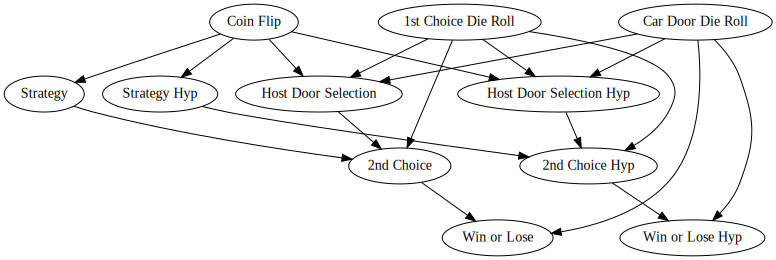

In [7]:
from pgmpy.models import BayesianNetwork

exogenous_vars = ["Car Door Die Roll", "Coin Flip", "1st Choice Die Roll"]    #A
endogenous_vars = ["Host Door Selection", "Strategy", "2nd Choice", "Win or Lose"]    #A

actual_world_edges = [    #B
    ('Coin Flip', 'Host Door Selection'),    #B
    ('Coin Flip', 'Strategy'),    #B
    ('Car Door Die Roll', 'Host Door Selection'),    #B
    ('1st Choice Die Roll', 'Host Door Selection'),    #B
    ('1st Choice Die Roll', '2nd Choice'),    #B
    ('Host Door Selection', '2nd Choice'),    #B
    ('Strategy', '2nd Choice'),    #B
    ('2nd Choice', 'Win or Lose'),    #B
    ('Car Door Die Roll', 'Win or Lose')    #B
]    #B

possible_world_edges = [    #C
    (a + " Hyp" if a in endogenous_vars else a,    #C
     b + " Hyp" if b in endogenous_vars else b)    #C
    for a, b in actual_world_edges    #C
]    #C

twin_world_graph = BayesianNetwork(    #D
    actual_world_edges +    #D
    possible_world_edges    #D
)    #D

twin_world_graph.add_cpds(    #E
    p_door_with_car,    #F
    p_player_first_choice,    #F
    p_coin_flip,    #F
    f_strategy,    #G
    f_host_door_selection,    #G
    f_second_choice,    #G
    f_win_or_lose,    #G
    clone(f_strategy),    #H
    clone(f_host_door_selection),    #H
    clone(f_second_choice),    #H
    clone(f_win_or_lose),    #H
)

plot_graph(twin_world_graph)
#A Specify lists of the exogenous and endogenous variables in the causal DAG.
#B Specify the edges of the SCM
#C Clone the edges for the hypothetical world
#D Create parallel world graph
#E Plot the parallel world graph
#F Add probability distributions on exogenous variables
#G Add assignment functions from the SCM
#H Clone assignment functions

# Listing 9.8 Confirm correct probability of winning given a switch strategy

Before we answer our counterfactual questions, we’ll do a quick sanity check to confirm our model can generate the result that the switching strategy leads to a win 2/3s of the time.

In [8]:
from pgmpy.inference import VariableElimination    #A
infer = VariableElimination(twin_world_graph)    #A
strategy_outcome = infer.query(    #B
    ['Win or Lose'],    #B
    evidence={"Strategy": "switch"}    #B
)    #B
print(strategy_outcome)
#A Instantiate inference algorithm with variable elimination
#B Infer the probability distribution “Win or Lose” given the player uses a switch strategy.

+-------------------+--------------------+
| Win or Lose       |   phi(Win or Lose) |
+===================+====================+
| Win or Lose(win)  |             0.6667 |
+-------------------+--------------------+
| Win or Lose(lose) |             0.3333 |
+-------------------+--------------------+


# Listing 9.9 Infer the counterfactual distributions

Finally, we use inference to answer our counterfactual questions.

* For a player who stayed with their first door and lost, what is the probability that they would have won if they switched doors?
* For a player who lost, what is the probability they would have won if they switched doors?

Again, we use variable elimination as our choice of inference algorithm. We’ll use the do function to do the action step and implement the hypothetical condition of switching. Then, we’ll use the inference algorithm VariableElimination to do the abduction and prediction steps all in one go.

In [9]:
cf_model = do(twin_world_graph, {'Strategy Hyp': 'switch'})    #A
infer = VariableElimination(cf_model)    #B

cf_dist1 = infer.query(    #C
    ['Win or Lose Hyp'],    #C
    evidence={'Strategy': 'stay', 'Win or Lose': 'lose'}    #C
)    #C
print(cf_dist1)

cf_dist2 = infer.query(    #D
    ['Win or Lose Hyp'],    #D
    evidence={'Win or Lose': 'lose'}    #D
)    #D
print(cf_dist2)
#A Action Step: Set "Strategy Hyp" to "switch" using “do”, and implementation of an ideal intervention.
#B We apply variable elimination as our inference algorithm on the parallel world graph.
#C The inference query that answers "For a player who used the 'stay' strategy and lost, would they have won if they used the "switch" strategy? Conditional on Strategy == stay and 'Win or Lose' == lose, we infer the probability distribution of 'Win or Lose Hyp' on the parallel world graph.
#D The inference query that answers "For a player who lost, would they have won if they used the "switch" strategy. Conditional on 'Win or Lose' == lose, we infer the probability distribution of 'Win or Lose Hyp' on the parallel world graph.


+-----------------------+------------------------+
| Win or Lose Hyp       |   phi(Win or Lose Hyp) |
+=======================+========================+
| Win or Lose Hyp(win)  |                 1.0000 |
+-----------------------+------------------------+
| Win or Lose Hyp(lose) |                 0.0000 |
+-----------------------+------------------------+
+-----------------------+------------------------+
| Win or Lose Hyp       |   phi(Win or Lose Hyp) |
+=======================+========================+
| Win or Lose Hyp(win)  |                 0.6667 |
+-----------------------+------------------------+
| Win or Lose Hyp(lose) |                 0.3333 |
+-----------------------+------------------------+


# Femur and Height Model

We turn back to our femur and height model. To make things more interesting, we'll modify the model by adding a variable for biological sex, which drives both femur length and height. The following image illustrates the new causal DAG.

![DAG](https://github.com/altdeep/causalML/blob/master/book/chapter%209/images/causalDAG.png?raw=true)

## Listing 9.10 Implement the femur SCM in pyro

Notice our questions do not mention anything about sex, so we'll expect to see sex-related variance in our distributions $P(H_{F=46})$ and $P(H_{F=46}|F=44, H=165)$.

In [10]:
!pip install pyro-ppl

In [11]:
import matplotlib.pyplot as plt
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro.distributions import Bernoulli, Delta, Normal
from pyro.infer import SVI, Trace_ELBO
from pyro import sample
from pyro.optim import Adam
from pyro.primitives import param

from functools import partial    #A
PseudoDelta = partial(Normal, scale=.01)    #A

def f_sex(N_sex):    #B
    return sample("sex", Bernoulli(N_sex))    #B

def f_femur(sex, N_femur):    #C
    if sex == tensor(1.0):    #C
        μ = 43.7 + 2.3 * N_femur    #C
    else:    #C
        μ = 40.238 + 1.9 * N_femur    #C
    return sample("femur", PseudoDelta(μ))    #C

def f_height(femur, sex, N_height):    #D
    if sex == tensor(1.0):    #D
        μ = 61.41 + 2.21 * femur + 7.62 * N_height    #D
    else:    #D
        μ = 54.1 + 2.47 * femur + 7 * N_height    #D
    return sample("height", PseudoDelta(μ))    #D

def model(exogenous):
    N_sex = sample("N_sex", exogenous['N_sex'])    #E
    N_femur = sample("N_femur", exogenous['N_femur'])    #E
    N_height = sample("N_height", exogenous['N_height'])    #E

    sex = f_sex(N_sex)    #F
    femur = f_femur(sex, N_femur)    #F
    height = f_height(femur, sex, N_height)    #F
    return sex, femur, height

exogenous = {    #G
    'N_sex': Bernoulli(.5),    #G
    'N_femur': Normal(0., 1.),    #G
    'N_height': Normal(0., 1.),    #G
}    #G

#A Endogenous variables are deterministic functions of the exogenous variables. But for variational inference to work, we must assign the endogenous variables a distribution using pyro.sample. We could use the Dirac delta distribution, which would assign all probability value to the output of a variable's assignment function. But gradient-based optimization won't work in this case. So instead, we do approximate inference with a "pseudo-delta" distribution, a Normal distribution with a very small scale parameter.
#B The assignment function for biological sex.
#C The assignment function for femur length in cm. The assignment uses two linear functions, one for each sex.
#D The assignment function for height. Again, it uses two linear functions, one for each sex.
#E Sample from the exogenous variable prior distributions.
#F Obtain the endogenous variables given the exogenous variables.
#G Specify the prior distributions for the exogenous variables.

## Listing 9.11 Sampling from the intervention distribution representing “if femur length were 46cm”

Now, let's pose the conditional hypothetical "What would height be if femur length was 46cm?" The following figure illustrates the mutilated DAG representing the ideal intervention that sets femur length to 46.

![femur](https://github.com/altdeep/causalML/blob/master/book/chapter%209/images/causalDAG_int.png?raw=true)


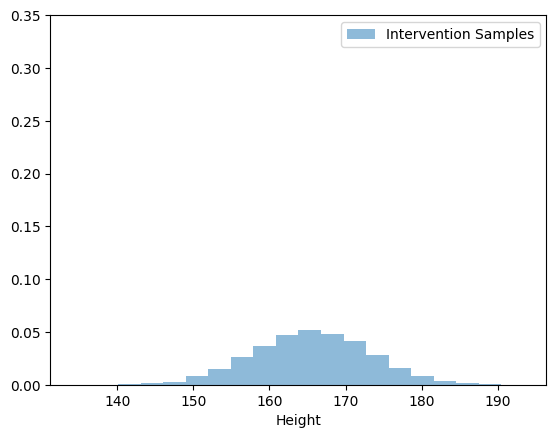

In [12]:
int_model = pyro.do(model, data={"femur": tensor(46.0)})    #A

int_samples = []    #B
for _ in range(10000):    #B
    _, _, int_height = int_model(exogenous)    #B
    int_samples.append(float(int_height))    #B

plt.hist(    #C
    int_samples,    #C
    bins=20,    #C
    alpha=0.5,    #C
    label="Intervention Samples",    #C
    density=True    #C
)
plt.ylim(0., .35)    #C
plt.legend()    #C
plt.xlabel("Height")    #C
plt.show()    #C

#A Implement the hypothetical condition "...if femur length were 46cm" with pyro.do, which returns a new model that implements the intervention.
#B Sample from the intervention distribution.
#C Visualize the intervention distribution with a histogram of samples.

## Listing 9.12 Specifying the guide function for variational inference

Our conditional hypothetical question was, "What would an individual's height be if their femur length was 46cm?" Now we want to answer the counterfactual: "An individual's femur is 44cm, and their height is 165cm. What would their height be if femur length was 46cm?" I.e., we want to extend P(H_{F=46}) to P(H_{F=46}|F=44, H=165).

The following image illustrates the corresponding parallel world graph.

![counterfactual parallel world graph](https://github.com/altdeep/causalML/blob/master/book/chapter%209/images/causalDAG_cf.png?raw=true)

In [13]:
def guide(exogenous):    #A
    p = param("p", tensor(.5), constraint=constraints.unit_interval)    #B
    n_sex = sample("N_sex", Bernoulli(p))    #B
    sex = sample("sex", Bernoulli(n_sex))    #C
    n_femur_loc = param("n_femur_loc", tensor(0.0))    #D
    n_femur_scale = param(    #D
        "n_femur_scale",    #D
        tensor(1.0),    #D
        constraint=constraints.positive    #D
    )    #D
    n_femur = sample("N_femur", Normal(n_femur_loc, n_femur_scale))    #E
    n_height_loc = param("n_height_loc", tensor(0.0))    #E
    n_height_scale = param(    #E
        "n_height_scale",    #E
        tensor(1.0),    #E
        constraint=constraints.positive    #E
    )    #E
    n_height = sample("N_height", Normal(n_height_loc, n_height_scale))    #E
    femur = sample("femur", Delta(n_femur))    #F
    height = sample("height", Delta(n_height))    #F
#A The exogenous prior distribution is passed to the guide function. The function won't use this argument, but the signatures of the guide and the model functions must match.
#B The guide function tries to approximate P(N_sex|femur, height) from a Bernoulli distribution. Optimization targets the parameter of this Bernoulli distribution.
#C n_sex is either 0 or 1. When passed as a parameter to a Bernoulli, the outcome is deterministic.
#D The guide function tries to approximate P(N_femur|femur, height) from a Normal distribution. Optimization targets the location and scale parameters of this Normal distribution.
#E The guide function tries to approximate P(N_height|femur, height) also from a Normal distribution.
#F Since we condition on femur and height, they are not needed in the guide function. But it is useful to have them in case we want to condition on different outcomes in a new analysis.


## Listing 9.13 Conditioning on actual values of femur and height

In our abduction step, first, we condition the model on observed values of femur and height.

In [14]:
conditioned_model = pyro.condition(    #A
    model,    #A
    data={"femur": tensor(44.0), "height": tensor(165.0)}    #A
)    #A
#A Condition on actual world outcomes of a 44 cm femur and 165 cm height.

## Listing 9.14 Implementing the abduction step with variational inference

And next, we infer the exogenous variable given femur and height using variational inference.

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'femur', 'height'}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'femur', 'height'}
  warnings.warn(


Text(0, 0.5, 'loss')

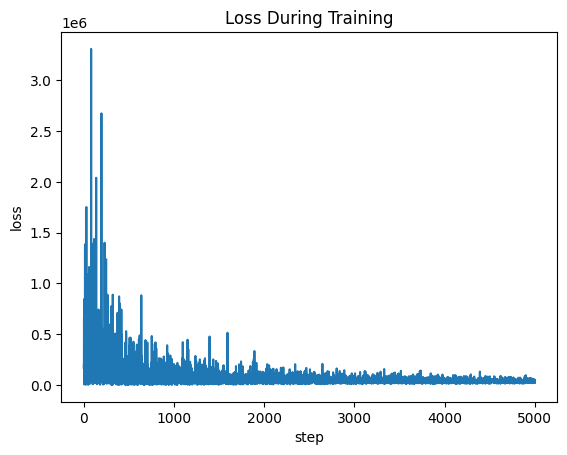

In [15]:
pyro.util.set_rng_seed(123)    #A
pyro.clear_param_store()    #B
svi = SVI(    #C
          model=conditioned_model,
          guide=guide,
          optim=Adam({"lr": 0.003}),    #D
          loss=Trace_ELBO()    #E
)

losses = []    #F
num_steps = 5000    #G
for t in range(num_steps):    #G
    losses.append(svi.step(exogenous))    #G

plt.plot(losses)    #H
plt.title("Loss During Training")    #H
plt.xlabel("step")    #H
plt.ylabel("loss")    #H
#A Set seed for reproducibility
#B Clear any current parameter values
#C Initialize the stochastic variational inference algorithm.
#D Optimize the parameters with a learning rate of .003.
#E Use (negative) evidence lower bound (ELBO) as the loss function.
#F Initialize a list to store loss values for plotting.
#G Run the optimization for 5000 steps. The SVI’s step object has the same signature as the model and the guide, so any model/guide arguments must be passed in here.
#H Plot the loss during training.

## Listing 9.15 Extract parameters of updated exogenous distribution

After training is completed, we extract the optimized parameters for our updated exogenous variable distribution.

In [16]:
n_sex_p = param("p").item()    #A
n_femur_loc = param("n_femur_loc").item()    #A
n_femur_scale = param("n_femur_scale").item()    #A
n_height_loc = param("n_height_loc").item()    #A
n_height_scale = param("n_height_scale").item()    #A

exogenous_posterior = {    #B
    'N_sex': Bernoulli(n_sex_p),    #B
    'N_femur': Normal(n_femur_loc, n_femur_scale),    #B
    'N_height': Normal(n_height_loc, n_height_scale),    #B
}    #B
#A Extract the parameter values.
#B Do the abduction step by using the optimized parameters to create new “posterior” exogenous variable distributions.

## Listing 9.16 Sampling from the counterfactual distribution.

In the Monty Hall example, we built the parallel world model explicitly. In this example, we can just do the action step by using `pyro.do` to get the hypothetical world model and sample from this model using the updated exogenous variable distribution.
I repeat the procedure of generating samples from the intervention model that set femur length to 46cm. Only we already did this in Listing 9.11 with the line:

`int_model = pyro.do(model, data={"femur": tensor(46.0)})`

To sample from intervention distribution, we called int_model on our original exogenous variable distribution. Now, for the prediction step, we'll call it again, this time with `exogenous_posterior` instead of exogenous, as `exogenous_posterior` encodes all the information from the "actual world."


In [17]:
cf_samples = []    #A
for _ in range(10000):    #A
    _, _, cf_height = int_model(exogenous_posterior)    #A
    cf_samples.append(float(cf_height))    #A
#A Generate counterfactual samples by passing the posterior on noise variables to the intervention model.

## Listing 9.17 Comparing the interventional and counterfactual distibutions

Finally, we overlay a histogram of samples from the counterfactual distribution against the interventional distribution histogram and see the clear differences between these distributions.


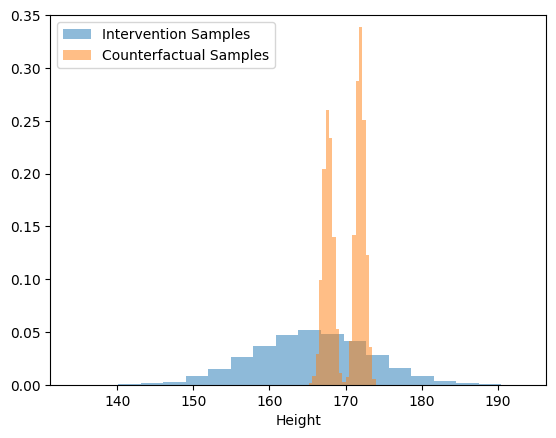

In [18]:
plt.hist(    #A
    int_samples,    #A
    bins=20,    #A
    alpha=0.5,    #A
    label="Intervention Samples",    #A
    density=True    #A
)
plt.hist(    #A
    cf_samples,    #A
    bins=20,    #A
    alpha=0.5,    #A
    label="Counterfactual Samples",    #A
    density=True    #A
)    #A
plt.ylim(0., .35)    #A
plt.legend()    #A
plt.xlabel("Height")    #A
plt.show()    #A
#A Overlay both the interventional and counterfactual histograms.


# Counterfactual reasoning with an dSprites VAE

The dSprites dataset consists of 2D shapes, each rendered in eight possible positions, six possible scales, and forty possible rotations. The shapes are composed of five independent factors: shape, scale, rotation, x-position, and y-position.

![dsprites DAG](https://github.com/altdeep/causalML/blob/master/book/chapter%209/images/dsprites_parallel.png?raw=true)

## Listing 9.18 Load a dSprites image

Let's start by loading an image from the dataset.


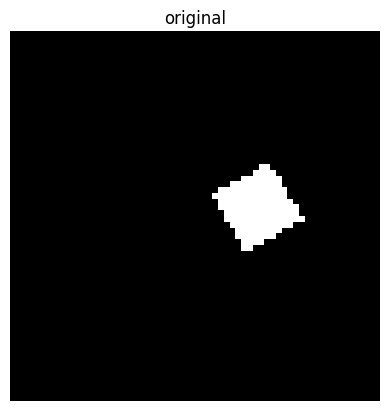

tensor([[ 0,  0,  1, 13, 26, 14]])


In [19]:
import io    #A
import urllib.request    #A
import numpy as np    #A
import torch
from matplotlib import pyplot as plt


url = 'https://github.com/altdeep/causalML/blob/master/book/chapter%209/sprites_example.npz?raw=true'    #A
with urllib.request.urlopen(url) as response:    #A
    data = response.read()    #A
file = io.BytesIO(data)    #A
npzfile = np.load(file)    #A
img_dict = dict(npzfile)    #A
img = torch.tensor(img_dict['image'].astype(np.float32) )   #B
plt.imshow(img, cmap='Greys_r', interpolation='nearest')    #B
plt.axis('off')    #B
plt.title('original')    #B
plt.show()    #B
causal_factor = torch.from_numpy(img_dict['label']).unsqueeze(0)    #C
print(causal_factor)    #C
#A Download dSprites example from GitHub and load it.
#B Download the dSprites image.
#C The causal factors of the example is [0  0  1 13 26 14], the first element is always 0, the second element corresponds to "square" and is represented by 0. The remaining elements correspond to scale, orientation, and X and Y positions.


## Listing 9.19 Load the encoder of causal factors

First, I load a pretrained encoder to map from the image to the exogenous variable for the causal factors. In this simple model, we'll assume the assignment functions for the exogenous variables of the causal factors and the causal factors are identity functions, i.e., the causal factors and their exogenous variables will have the same values.

In [20]:
import requests
import torch.nn as nn

CARDINALITY = [1, 3, 6, 40, 32, 32]    #A

class EncoderCausalFactors(nn.Module):    #B
    def __init__(self, image_dim, factor_dim):
        super(EncoderCausalFactors, self).__init__()
        self.image_dim = image_dim
        self.factor_dim = factor_dim
        hidden_dim = 1000    #C
        self.fc1 = nn.Linear(image_dim, hidden_dim)    #D
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #D
        self.fc3 = nn.Linear(hidden_dim, factor_dim)    #D
        self.softplus = nn.Softplus()    #D
        self.sigmoid = nn.Sigmoid()    #E

    def forward(self, img):
        img = img.reshape(-1, self.image_dim)    #F
        hidden1 = self.softplus(self.fc1(img))    #G
        hidden2 = self.softplus(self.fc2(hidden1))    #G
        p_loc = self.sigmoid(self.fc3(hidden2))    #H
        return p_loc    #H

encoder_n_causal_factors = EncoderCausalFactors(    #I
    image_dim=64*64,    #I
    factor_dim=sum(CARDINALITY)    #I
)    #I

url = 'https://github.com/altdeep/causalML/raw/master/book/chapter%209/sprites-model-encoder-causal-factors.pt'    #J
response = requests.get(url)    #J
response.raise_for_status()    #J
with open('temp_weights.pt', 'wb') as f:    #J
    f.write(response.content)    #J
state_dict = torch.load(    #J
    'temp_weights.pt',    #J
    map_location=torch.device('cpu')    #J
)    #J
encoder_n_causal_factors.load_state_dict(state_dict)    #J

#A Cardinality in each dimensionality of the causal factors
#B Encoder for the the vector of exogenous parents of the causal factors.
#C The hidden layers have a length of 1000.
#D Using linear transforms passed through softplus activation functions.
#E The final activation is a sigmoid function.
#F Flatten the image.
#G Calculate the hidden layers.
#H The output layer generates a probability vector passed OneHotCategorical distribution.
#I Initialize the encoder. The image dimension is 64x64 pixels and the six elements of the causal factor vector are one-hot encoded into a vector of length 1+3+6+40+32+32=114
#J Download the pre-trained weights to a temporary file and load them into the model. You can download the weights from 'https://github.com/altdeep/causalML/blob/master/book/chapter%209/sprites-model-encoder-causal-factors.pt?raw=true'

<All keys matched successfully>

# Listing 9.20 Generate examples of causal exogenous factors

First, I test that the encoder can recover the causal factors from the image.

In [21]:
from pyro import distributions as dist

def decode_one_hot(factor_encoded, cardinality=CARDINALITY):    #A
    split = [    #A
        torch.split(element, cardinality)     #A
        for element in factor_encoded    #A
    ]    #A
    labels = [[int(torch.argmax(vec)) for vec in item] for item in split]    #A
    return torch.tensor(labels)    #A

def sample_one_hot(p_encoded, cardinality=CARDINALITY):    #B
    split = [torch.split(element, cardinality) for element in p_encoded]    #B
    sample_list = [    #B
        [    #B
            dist.OneHotCategorical(p_vec).sample()    #B
            for p_vec in item    #B
        ] for item in split    #B
    ]    #B
    sample = torch.stack([    #B
        torch.cat(samples, -1)    #B
        for samples in sample_list    #B
    ])    #B
    return sample    #B

inferred_cause_p = encoder_n_causal_factors.forward(img)    #C
sampled_factors = sample_one_hot(    #C
    inferred_cause_p    #C
)    #C
print(decode_one_hot(sampled_factors))    #C
#A Helper function that decodes the one-hot encoded output of the encoder.
#B Samples from the output probability vector of the encoder_causal_factors.
#C Use encoder to predict causal factors.

tensor([[ 0,  0,  1, 13, 26, 14]])


## Listing 9.21 An encoder for inference of $N_I$

Next, we initialize an encoder that we'll use for inference of NI, the exogenous variable for the image. This encoder takes an image and an instance of the causal factor vector as an input.

In [22]:
class EncoderNImage(nn.Module):    #A
    def __init__(self, image_dim, factor_dim, n_image_dim):
        super(EncoderNImage, self).__init__()
        self.image_dim = image_dim
        self.factor_dim = factor_dim
        self.n_image_dim = n_image_dim
        hidden_dim = 1000
        self.fc1 = nn.Linear(
            self.image_dim + self.factor_dim, hidden_dim    #B
        )    #B
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #B
        self.fc31 = nn.Linear(hidden_dim, n_image_dim)    #B
        self.fc32 = nn.Linear(hidden_dim, n_image_dim)    #B
        self.softplus = nn.Softplus()    #B

    def forward(self, img, factor):
        img = img.reshape(-1, self.image_dim)    #C
        inputs = torch.cat((img, factor), -1)    #D
        hidden1 = self.softplus(self.fc1(inputs))    #E
        hidden2 = self.softplus(self.fc2(hidden1))    #E
        n_image_loc = self.fc31(hidden2)    #F
        n_image_scale = torch.exp(self.fc32(hidden2))    #F
        return n_image_loc, n_image_scale    #F

def encode_one_hot(factor, cardinality=CARDINALITY):    #G
    new_factor = []    #G
    for i, factor_length in enumerate(cardinality):    #G
        new_factor.append(    #G
            torch.nn.functional.one_hot(    #G
                factor[:,i].to(torch.int64), int(factor_length)    #G
            )    #G
        )    #G
    new_factor = torch.cat(new_factor, -1)    #G
    return new_factor.to(torch.float32)    #G

encoder_n_image = EncoderNImage(    #H
    image_dim=64*64,    #H
    factor_dim=sum(CARDINALITY),    #H
    n_image_dim=50    #H
)    #H
url = "https://github.com/altdeep/causalML/raw/master/book/chapter%209/sprites-model-encoder-n-image.pt"    #I
response = requests.get(url)    #I
response.raise_for_status()    #I
with open('temp_weights.pt', 'wb') as f:    #I
    f.write(response.content)    #I
state_dict = torch.load(    #I
    'temp_weights.pt',    #I
    map_location=torch.device('cpu')    #I
)    #I
encoder_n_image.load_state_dict(state_dict)    #I

n_image_loc, n_image_scale = encoder_n_image.forward(    #J
    img,    #J
    encode_one_hot(causal_factor)    #J
)    #J
n_image = torch.normal(n_image_loc, n_image_scale)    #K

#A Encoder used for inference of $N_I$, which serves as both the exogenous variable for the image in causal terms, and the encoding of the image in VAE terms.
#B Using linear transforms passed into a softplus activation function.
#C Flatten the image.
#D Concatenate the image and the causal factor vector.
#E Calculate the hidden layers.
#F Calculate the location and scale parameter of multivariate normal distribution on N_image.
#G A helper function one-hot encoding a factor.
#H Initialize the encoder.
#I Load the pretrained weights. The weights are available from https://github.com/altdeep/causalML/blob/master/book/chapter%209/sprites-model-encoder-n-image.pt
#J pass the image and causal factors into the encoder and obtain $N_I$ location and scale parameters
#K Generate from the posterior distribution on $N_I$.

## Listing 9.22 Load and run the decoder that maps causes and $N_I$ to images

Finally, we load a decoder that maps from Ni and a causal factor back to an image. In causal terms, the decoder is part of the assignment function for the image.

In [23]:
class Decoder(nn.Module):    #A
    def __init__(self, image_dim, factor_dim, n_image_dim):
        super(Decoder, self).__init__()
        hidden_dim = 1000
        self.fc1 = nn.Linear(n_image_dim + factor_dim, hidden_dim)    #B
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)    #B
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)    #B
        self.fc4 = nn.Linear(hidden_dim, image_dim)    #B
        self.softplus = nn.Softplus()    #B
        self.sigmoid = nn.Sigmoid()    #B

    def forward(self, n_image, factor):
        inputs = torch.cat((n_image, factor), -1)    #C
        hidden1 = self.softplus(self.fc1(inputs))    #D
        hidden2 = self.softplus(self.fc2(hidden1))    #D
        hidden3 = self.softplus(self.fc3(hidden2))    #D
        p_img = self.sigmoid(self.fc4(hidden3))    #E
        return p_img    #E

decoder = Decoder(    #F
    image_dim=64*64,    #F
    factor_dim=sum(CARDINALITY),    #F
    n_image_dim=50    #F
)    #F

url = "https://github.com/altdeep/causalML/raw/master/book/chapter%209/sprites-model-decoder.pt"    #G
response = requests.get(url)    #G
response.raise_for_status()    #G
with open('temp_weights.pt', 'wb') as f:    #G
    f.write(response.content)    #G
state_dict = torch.load(    #G
    'temp_weights.pt',    #G
    map_location=torch.device('cpu')    #G
)    #G
decoder.load_state_dict(state_dict)    #G
#A The decoder maps from causal factors and N_image to generate a parameter for a multivariate Bernoulli distribution on images.
#B The model uses linear transforms, a softplus activate for hidden layers, and sigmoid activate on the output layer.
#C The network concatenates n_image and factors in the input layer.
#D The input is passed through three hidden layers with softplus activation functions.
#E The output is a probability parameter passed to a multivariate Bernoulli distribution on image pixels.
#F Initialize the decoder.
#G Load the pretrained weights. The weights are available at https://github.com/altdeep/causalML/blob/master/book/chapter%209/sprites-model-decoder.pt

<All keys matched successfully>

## Listing 9.23 Helper function for plotting counterfactual image

Before we generate the counterfactual image, we create a helper function to plot it.

In [24]:
def compare_reconstruction(original, generated):    #A
    fig = plt.figure()    #A
    ax0 = fig.add_subplot(121)    #A
    plt.imshow(    #A
        original.cpu().reshape(64, 64),    #A
        cmap='Greys_r',    #A
        interpolation='nearest'    #A
    )    #A
    plt.axis('off')    #A
    plt.title('actual')    #A
    ax1 = fig.add_subplot(122)    #A
    plt.imshow(    #A
        generated.reshape(64, 64),    #A
        cmap='Greys_r', interpolation='nearest')    #A
    plt.axis('off')    #A
    plt.title('counterfactual')    #A
    plt.show()    #A
#A The help function plots the original and counterfactual image side-by-side

## Listing 9.24 Create exogenous distribution and assignment function for the image

Now, we specify the SCM. We write a function `p_n_image` that generates from $P(N_{image})$ and fan assignment function $f_{image}$ for the image.


In [25]:
def p_n_image(n_image_params):    #A
    n_image_loc, n_image_scale, n_unif_upper = n_image_params    #B
    n_image_norm = dist.Normal(n_image_loc, n_image_scale    #C
    ).to_event(1).sample()    #C
    n_image_unif = dist.Uniform(0, n_unif_upper).expand(    #D
        torch.Size([1, 64*64])    #D
    ).sample()    #D
    n_image = n_image_norm, n_image_unif    #E
    return n_image

def f_image(factor, n_image):    #F
    n_image_norm, n_image_unif = n_image    #G
    p_output = decoder.forward(    #H
        n_image_norm,    #H
        encode_one_hot(factor)    #H
    )    #H
    sim_img = (n_image_unif <= p_output).int()    #I
    return sim_img
#A A function that generates a variate from the N_image exogenous distribution.
#B The parameters the N_image's distribution include location and scale parameter for a normal distribution and the upper bound of a uniform distribution.
#C Sample a normal random variate from the Normal distribution.
#D Sample a uniform random variate from a Uniform distribution.
#E We combine these into a single n_image object.
#F Assignment function for the image.
#G The exogenous noise variable decomposes into one normal and one uniform random variate.
#H The normal random variate is passed through the decoder to get a probability vector for the pixels.
#I Each pixel is set deterministically with an indicator function that returns 1 if an element of the uniform variate is less than the corresponding element of the probability vector, or otherwise returns 0.


# Listing 9.25 Generate a counterfactual image

Finally, we can run through the steps of the counterfactual inference algorithm to answer the question, "what would this image look like if it was a heart?"

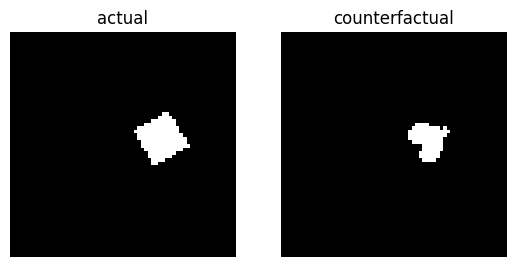

In [26]:
def abduct(img, factor, smoother=1e-3):    #A
    n_image_loc, n_image_scale = encoder_n_image.forward(    #B
        img, encode_one_hot(factor)    #B
    )    #B
    n_unif_upper = decoder.forward(    #C
        n_image_loc,    #C
        encode_one_hot(factor)    #C
    )    #C
    n_unif_upper = n_unif_upper * (1 - 2 * smoother) + smoother    #C
    p_image_params = n_image_loc, n_image_scale, n_unif_upper    #D
    return p_image_params

def do_action(factor, element=1, val=2):    #E
    intervened_factor = factor.clone()    #E
    intervened_factor[0][element] = val    #E
    return intervened_factor    #E

def predict(intervened_factor, n_image_params):    #F
    n_image = p_n_image(n_image_params)    #F
    sim_img = f_image(intervened_factor, n_image)    #F
    return sim_img    #F

def counterfactual(img, factor):    #G
    p_image_params = abduct(img, factor)    #G
    intervened_factor = do_action(factor)    #G
    pred_recon = predict(intervened_factor, p_image_params)    #G
    compare_reconstruction(img, pred_recon)    #G

counterfactual(img, causal_factor)    #H
#A Abduction step: Infer the exogenous variable given the image.
#B Infer the parameters of N_I. First, this includes two parameters of a normal distribution.
#C Secondly, we infer the upper bound of a uniform distribution and apply smoothing so it is not exactly 1 or 0.
#D Combine these together into one inferred parameter set.
#E Action step: Apply the intervention that sets the shape element to "heart" (represented by the integer 2).
#F Prediction step: Generate n_image from P(N_image), pass this through assignment function to generate an image.
#G Apply all three steps, "abduct" the n_image, apply the intervention, forward generate the counterfactual image.
#H Plot the result.